<div style="border-radius:10px; padding: 30px; background-color: #ADD8E6; font-size:90%; text-align:left">
    <p style="font-family:Georgia; font-size:400%;font-weight:bold;text-align:center;color:darkred;">
        🎨 Anime Face Generation 🖼️
    </p>
    <p style="font-family:NewTimesRoman; font-size:300%;font-weight:bold;text-align:center;color:purple;">
        Powered by 🤖 Generative Adversarial Networks (GANs) ⚡
    </p>
    <p style="font-family:NewTimesRoman; font-size:200%;font-weight:bold;text-align:center;color:darkblue;">
        Coder: Hamed Mahmoudi 👨‍💻
    </p>
</div>

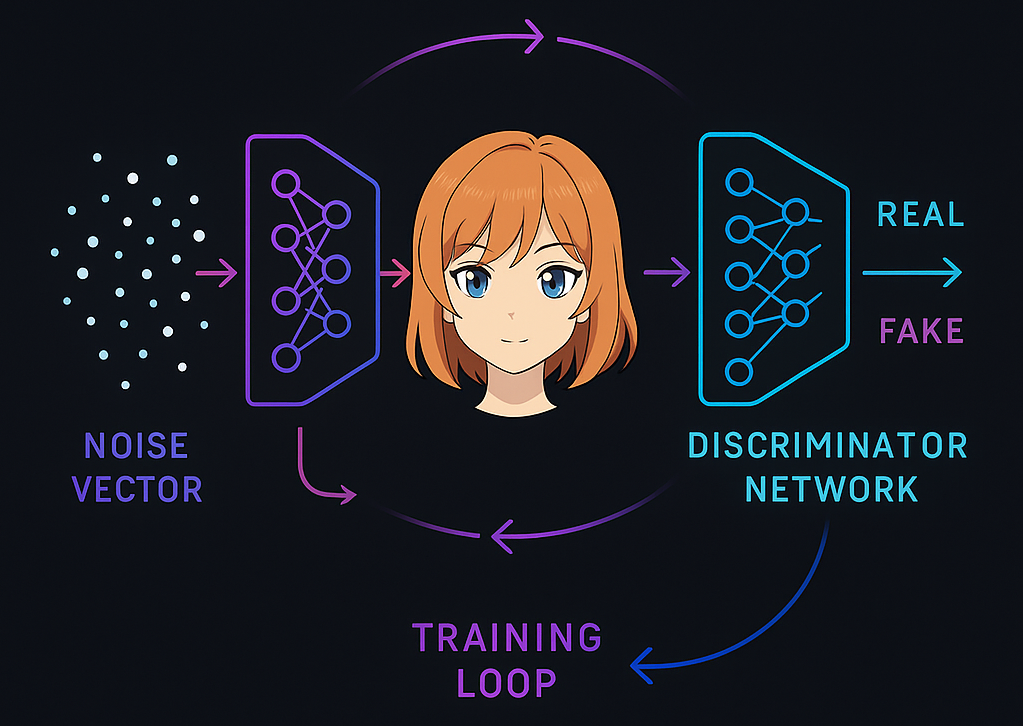

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <h3 align="left"><font color="navy">🎨 Anime Face Generation with GANs 🤖</font></h3>
    <p style="color:navy;">
        Generating high-quality anime faces is an exciting challenge in the field of computer vision and generative modeling 🌟. This notebook explores how Generative Adversarial Networks (GANs) 🧠 can be trained to create realistic and visually appealing anime-style faces 👩‍🎨.
        The project involves building and training a GAN architecture from scratch, working with a dataset of anime characters, and visualizing the generator's progress over time 🖼️. 
        While the results are fascinating, this notebook serves as an experimental and educational exploration into the capabilities of GANs in the creative AI space. 🎯
    </p>
</div>

<a id="c_table"></a> 

<div style="border-radius:10px; padding: 15px; background-color: #c0e5e9; font-size:115%; text-align:left">

<h3 align="left"><font color=navy>Table of Contents:</font></h3>
<font color=navy>
        
* [1 | Libraries & Setup ⚙️](#lib)
* [2 | Exploring the Dataset 🗄](#data)
* [3 | Preprocessing🎓](#preprocessing)
* [4 | importing dataset 🗂](#importing_data)
* [5 | GAN📊](#GAN)
* [6 | Results & Generated Faces 😸](#result)

<a id="lib"></a>
# <p style="background-color:powderblue; font-family:roboto; color:navy; font-size:145%;font-weight:bold; text-align:center; border-radius:25px 10px; padding: 10px">1 - Libraries & Setup ⚙️</p>

⬆️ [Table of Contents](#c_table)

In [5]:
# Install tensorflow_docs for visualization utilities (used later for embedding visuals in notebooks)
!pip install -q tensorflow_docs --upgrade
!pip install -q visualkeras --upgrade

In [6]:
# ----------------------- Standard Libraries -----------------------

import os  # Used for directory path handling, file navigation, and saving outputs
import glob  # Useful for finding files matching a specific pattern (e.g., loading all images)
import time  # Used to time training steps or for logging elapsed time
import shutil  # Used for copying images to directories, e.g., copying HQ images
import random  # Used for randomly selecting images, e.g., for visualizing random samples
from collections import Counter  # Used to count occurrences of different image shapes (for analysis)

# ----------------------- Image Handling Libraries -----------------------

from PIL import Image  # Used for opening, resizing, or saving images (e.g., loading images for display)
import cv2  # Used for faster image loading and shape analysis (e.g., getting image dimensions)
import imageio  # Used for saving generated images as GIFs to visualize GAN training progress

# ----------------------- ML & Deep Learning -----------------------

import numpy as np  # Essential for matrix/tensor operations, image array processing (e.g., normalizing images)
import visualkeras
import tensorflow as tf  # Core ML framework — for building and training the GAN
from tensorflow.keras import layers  # Required for constructing the generator and discriminator networks
from tensorflow.keras.utils import image_dataset_from_directory  # For loading and preprocessing image datasets

# ----------------------- Visualization -----------------------

import matplotlib.pyplot as plt  # Used to plot image samples, training losses, or progress
from matplotlib.animation import FuncAnimation, PillowWriter  # Used for creating animated GIFs from training outputs
from IPython import display  # Used to clear output during training for cleaner notebook presentation
from IPython.display import Image as IPyImage, display  # Used to display images or GIFs inline within the notebook

import tensorflow_docs.vis.embed as embed  # Used to embed visual outputs such as training GIFs in notebook cells

<a id="data"></a>
# <p style="background-color:powderblue; font-family:roboto; color:navy; font-size:145%;font-weight:bold; text-align:center; border-radius:25px 10px; padding: 10px">2 - Exploring the Dataset 🗄</p>

⬆️ [Table of Contents](#c_table)

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        The following code randomly selects 5 images from the dataset 📸 using <b>random.sample</b> and displays them for a quick preview 🔍. The random seed ensures reproducibility 🔄.
    </p>
</div>


In [7]:
image_dir = "/kaggle/input/animefacedataset/images"

image_names = os.listdir(image_dir) 

random.seed(5)
random_images = random.sample(image_names, 5)
print("the total number of images are : ", len(image_names))
print("randomly selected images are : ", random_images)

the total number of images are :  63565
randomly selected images are :  ['29028_2010.jpg', '36078_2011.jpg', '42911_2013.jpg', '53824_2016.jpg', '63094_2019.jpg']


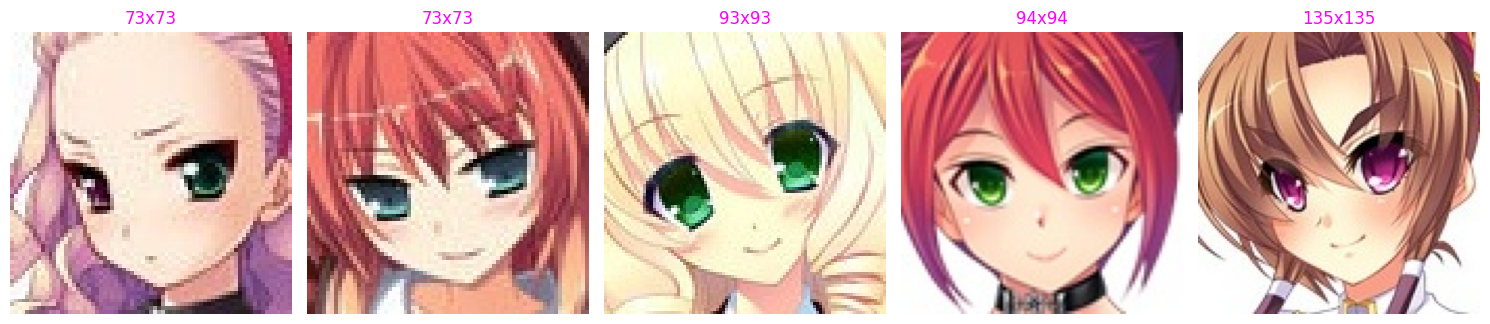

In [8]:
plt.figure(figsize=(15, 5))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    width, height = img.size
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{width}x{height}", color = 'magenta')
    
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        After visualizing the images, we found that the shapes are not the same 📏. In the following code, we extract the images with width > 96 📸 and identify non-square images 🟩. We also find the smallest and largest images by area 🔍 to address these shape variations.
    </p>
</div>


In [9]:
# Store image sizes and non-square images
image_shapes = []
non_square_images = []
HQ_images_pathes = []

# Iterate through files in the folder
for filename in image_names:
    file_path = os.path.join(image_dir, filename)

    img = cv2.imread(file_path)  # Faster loading
    height, width, _ = img.shape  # OpenCV uses (height, width, channels)

    image_shapes.append((filename, width, height))
    
    if width > 96:
        HQ_images_pathes.append(file_path)

    # Check if the image is not square
    if width != height:
        non_square_images.append((filename, width, height))

# Find smallest and largest images by area (width * height)
image_shapes.sort(key=lambda x: x[1] * x[2])  # Sort by area
smallest_shape = image_shapes[0]
largest_shape = image_shapes[-1]

Smallest image shape: ('30761_2010.jpg', 25, 25)
Largest image shape: ('26128_2009.jpg', 220, 220)


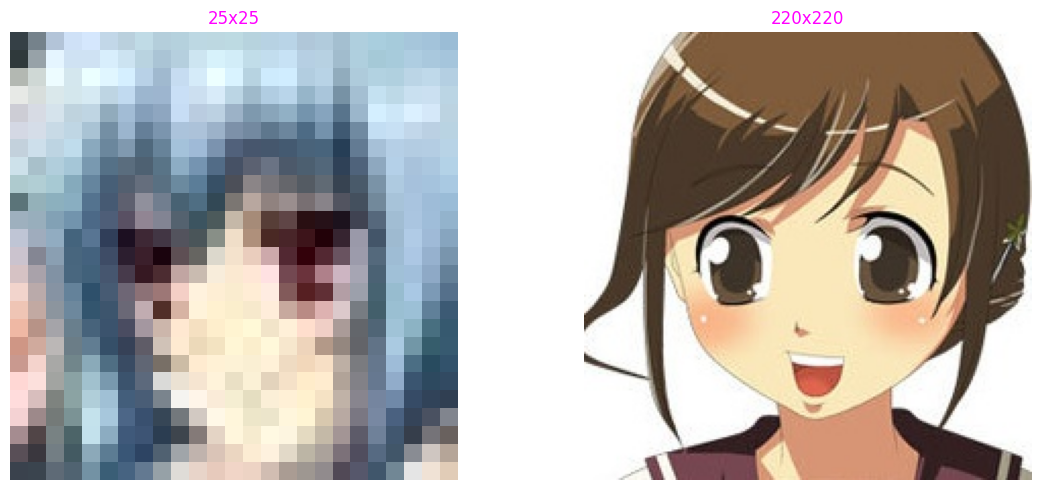

In [10]:
# Load images
smallest_img_path = os.path.join(image_dir, smallest_shape[0])
largest_img_path = os.path.join(image_dir, largest_shape[0])

smallest_img = Image.open(smallest_img_path)
largest_img = Image.open(largest_img_path)

# Get sizes
smallest_size = smallest_img.size
largest_size = largest_img.size

# Print shapes
print(f"Smallest image shape: {smallest_shape}")
print(f"Largest image shape: {largest_shape}")

# Display side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Smallest image
axs[0].imshow(smallest_img)
axs[0].axis("off")
axs[0].set_title(f"{smallest_size[0]}x{smallest_size[1]}", color='magenta')

# Largest image
axs[1].imshow(largest_img)
axs[1].axis("off")
axs[1].set_title(f"{largest_size[0]}x{largest_size[1]}", color='magenta')

plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        After displaying the smallest and largest images, we found that the smallest image has a shape of 25x25 pixels, which appears to be too blurry 🌀. The largest image has a shape of 220x220 pixels. To improve the quality of our dataset, we decided to exclude the small, blurry images from the project 🚫.
    </p>
</div>


<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        Next, we are checking for non-square images using the following code 🔍. If any non-square images were found, we will print their names along with their dimensions. If all images were square, we will receive a message confirming that 👌.
    </p>
</div>

In [11]:
# Check for non-square images
if non_square_images:
    print("\nNon-square images found:")
    for name, w, h in non_square_images:
        print(f"{name}: {w}x{h}")
else:
    print("\nAll images are square.")


Non-square images found:
4591_2003.jpg: 127x126
5895_2003.jpg: 102x101
44134_2013.jpg: 124x123
29340_2010.jpg: 88x87
3479_2002.jpg: 64x63
37072_2012.jpg: 97x96
13120_2005.jpg: 131x130
23095_2008.jpg: 186x185
854_2000.jpg: 52x51
39801_2012.jpg: 131x130
24061_2008.jpg: 113x112
46263_2014.jpg: 133x132
10276_2004.jpg: 124x123
6688_2003.jpg: 85x84
9948_2004.jpg: 93x92
36088_2011.jpg: 113x112
44130_2013.jpg: 124x123


<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        After running the code, we found several non-square images with a difference of just one pixel between their width and height. Since this difference is negligible, we decided to leave these images as they are and not exclude them from the dataset 📸. 
    </p>
    <p style="color:navy;">
        We know that GANs work better with square images, so when we import the images, we will reshape them to <b>128x128</b> for consistency and improved performance 🔄.
    </p>
</div>


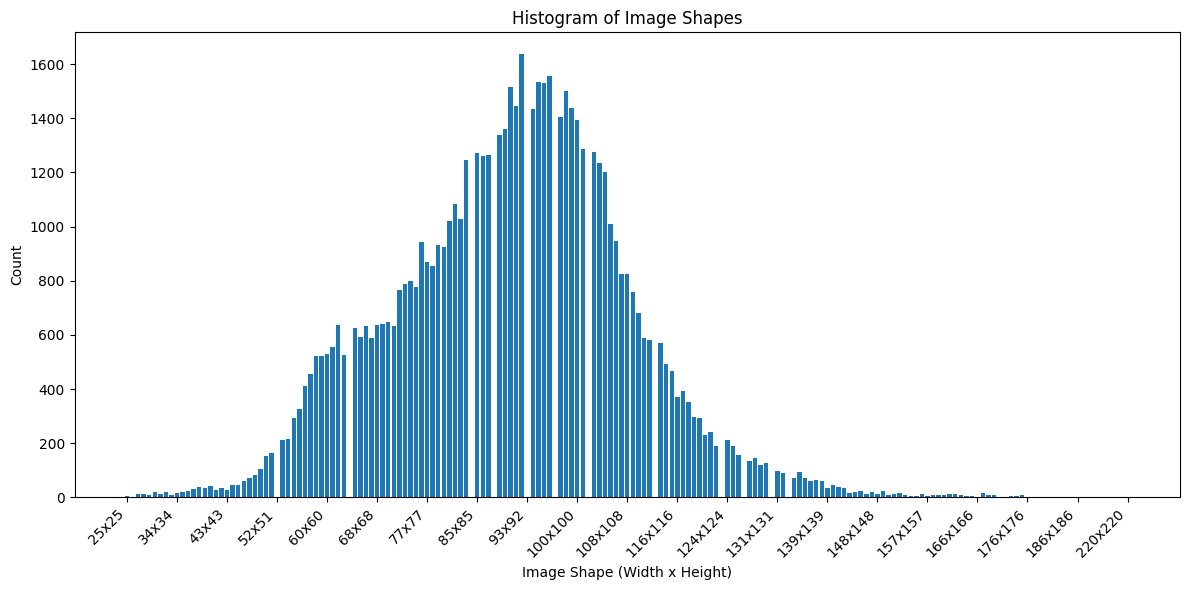

In [12]:
# Count occurrences of each unique shape

shape_counts = Counter((w, h) for _, w, h in image_shapes)

# Plot histogram
shapes, counts = zip(*shape_counts.items())  # Unpacking
shape_labels = [f"{w}x{h}" for w, h in shapes]

plt.figure(figsize=(12, 6))
plt.bar(shape_labels, counts)

# Show only some x-axis labels for better readability
step = max(1, len(shape_labels) // 20)  # Adjust step dynamically
plt.xticks(np.arange(0, len(shape_labels), step), shape_labels[::step], rotation=45, ha='right')

plt.xlabel("Image Shape (Width x Height)")
plt.ylabel("Count")
plt.title("Histogram of Image Shapes")
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        After plotting the histogram of image shapes, we found that the majority of the images have shapes ranging between <b>68x68</b> and <b>116x116</b> 📊. The distribution appears to be roughly normal, indicating a consistent spread of image sizes with a central tendency in this range 🌐.
    </p>
</div>

<a id="preprocessing"></a>
# <p style="background-color:powderblue; font-family:roboto; color:navy; font-size:145%;font-weight:bold; text-align:center; border-radius:25px 10px; padding: 10px">3 - Preprocessing🎓</p>

⬆️ [Table of Contents](#c_table)

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        First lets take a look at number of HQ images </p>
</div>

In [13]:
print("the number of HQ images : ", len(HQ_images_pathes))

the number of HQ images :  23059


<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        After running the code, we found that the number of HQ images is <b>23,059</b> 📦, which is about a third of the original dataset. To overcome this limitation, we will use data augmentation to generate more images, but first, we will copy the HQ images to a separate directory 📁.
    </p>
</div>


In [14]:
destination_dir = '/kaggle/working/Hq_images'
os.makedirs(destination_dir, exist_ok=True)

for image_path in HQ_images_pathes:
    shutil.copy(image_path, destination_dir)

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        After copying the HQ images to a separate directory 📁, we will use the <b>FLIP_LEFT_RIGHT</b> transformation for data augmentation. Flipping the images horizontally won't cause any loss of useful information, making it a suitable method to increase the dataset size 🔄.
    </p>
</div>

In [15]:
# Destination directory for flipped images
flipped_dir = destination_dir  # Same directory as HQ images

# Iterate through copied HQ images and flip them
for image_name in os.listdir(destination_dir):
    image_path = os.path.join(destination_dir, image_name)

    # Open image using PIL
    img = Image.open(image_path)

    # Flip image left to right
    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Create a new filename (e.g., "originalname_flipped.jpg")
    flipped_name = os.path.splitext(image_name)[0] + "_flipped" + os.path.splitext(image_name)[1]
    flipped_path = os.path.join(flipped_dir, flipped_name)

    # Save the flipped image
    flipped_img.save(flipped_path)

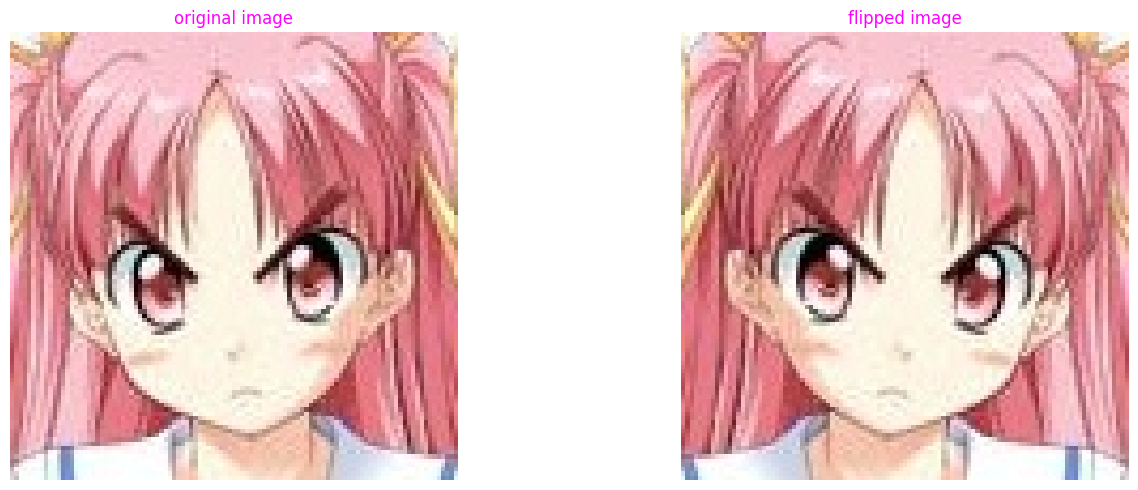

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"original image", color = 'magenta')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(flipped_img)
plt.title(f"flipped image", color = 'magenta')
plt.axis("off")
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        After flipping the images left to right, we found that the flipped images maintain their usefulness 🔄. Now, we are ready to use the augmented dataset to <b>train the model</b> 🎓.
    </p>
</div>

<a id="importing_data"></a>
# <p style="background-color:powderblue; font-family:roboto; color:navy; font-size:145%;font-weight:bold; text-align:center; border-radius:25px 10px; padding: 10px">4 - importing dataset 🗂</p>

⬆️ [Table of Contents](#c_table)

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        We use <b>image_dataset_from_directory</b> 📂 to efficiently load and resize images from the augmented dataset without keeping all of them in memory. 
        Images are resized to <b>128x128</b> 🟦 and loaded in <b>batches of 32</b> for optimized training!
    </p>
</div>

In [17]:
# Load dataset without keeping it entirely in memory
dataset = image_dataset_from_directory(
    destination_dir,
    label_mode=None,
    image_size=(128, 128),  # Resize images directly during loading
    batch_size=32  # Use a smaller batch size to reduce memory usage
)

Found 46118 files.


In [18]:
# Normalize images (inline processing for efficiency)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

# Prefetch to optimize training performance
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        A total of <b>46,118 images</b> 🖼️ were found.  
        We then <b>normalized</b> them to the range <b>[-1, 1]</b> ⚖️ for better GAN training, and applied <b>prefetching</b> 🚀 using <b>tf.data.AUTOTUNE</b> to boost performance during training.
    </p>
</div>


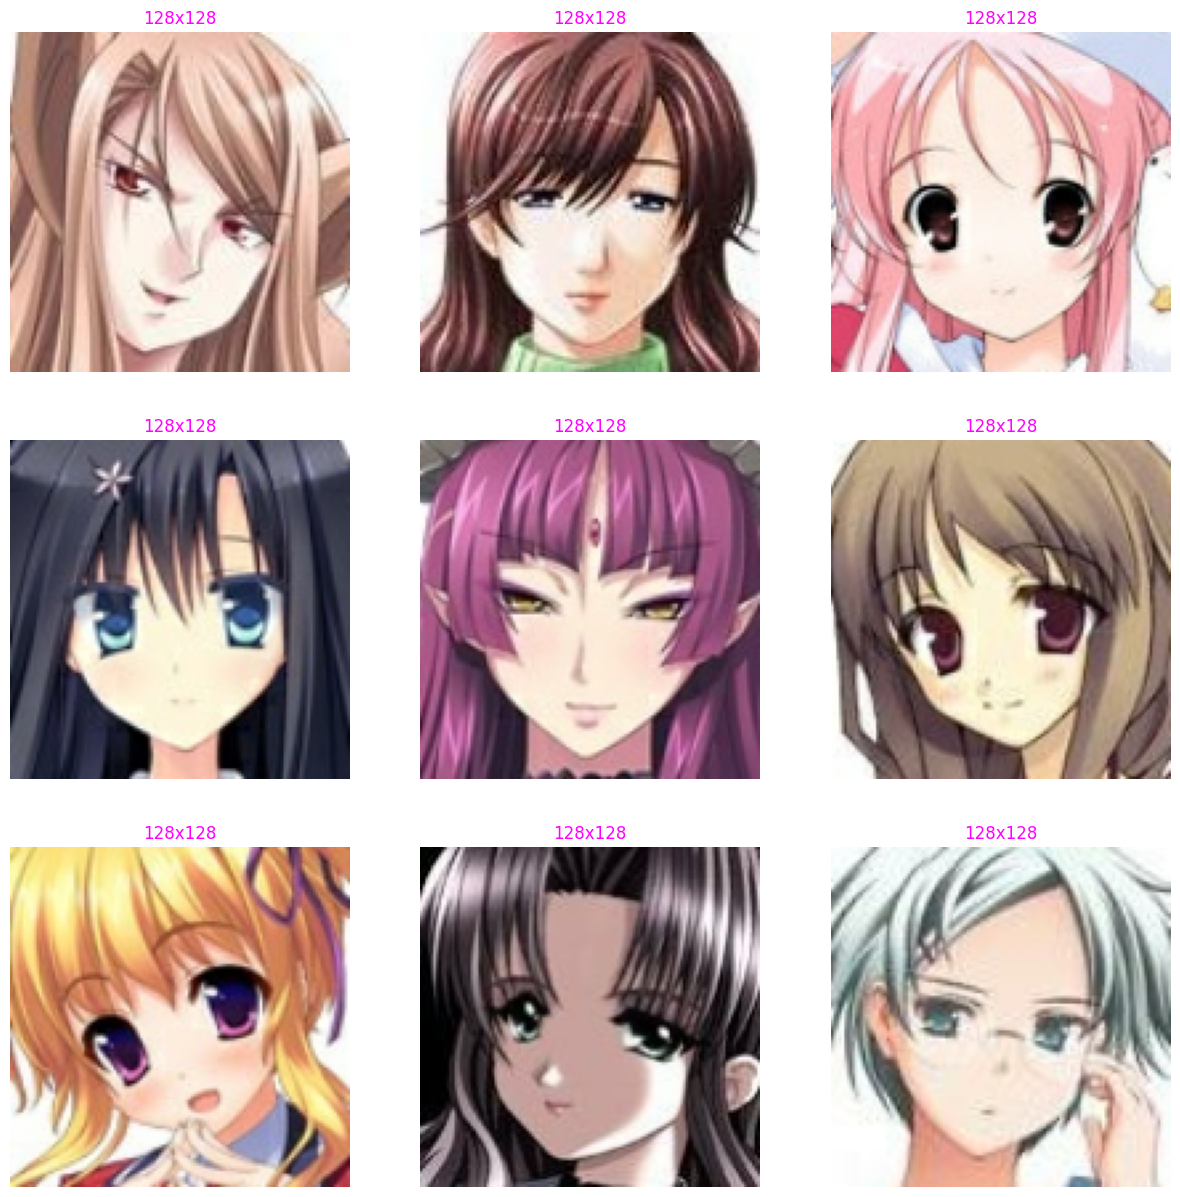

In [19]:
# Display some images from the dataset
def show_images(dataset, num_images=9):
    plt.figure(figsize=(15, 15))
    for image_batch in dataset.take(1):  # Take a single batch for display
        images = (image_batch.numpy() + 1.0) / 2.0  # Rescale to [0, 1]
        for i in range(min(num_images, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            width, height, _ = images[i].shape
            plt.title(f"{width}x{height}", color = 'magenta')
            plt.axis('off')
    plt.show()

# Call the function to visualize
show_images(dataset)

<a id="RNN"></a>
# <p style="background-color:powderblue; font-family:roboto; color:navy; font-size:145%;font-weight:bold; text-align:center; border-radius:25px 10px; padding: 10px">5 - GAN📊</p>

⬆️ [Table of Contents](#c_table)

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:navy;">
        We are going to define the <b>Generator</b> and <b>Discriminator</b> models 🛠️ using <b>tf.keras.Sequential</b>.  
        The <b>Generator</b> learns to create realistic anime faces 👧 from random noise, while the <b>Discriminator</b> tries to detect fakes 🚫.  
        This adversarial setup helps both networks improve together over time 🔁, which is the core idea behind GANs.
    </p>
</div>


In [27]:
# Model definitions
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(100,)),
        tf.keras.layers.Dense(8 * 8 * 256, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((8, 8, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()

In [28]:
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


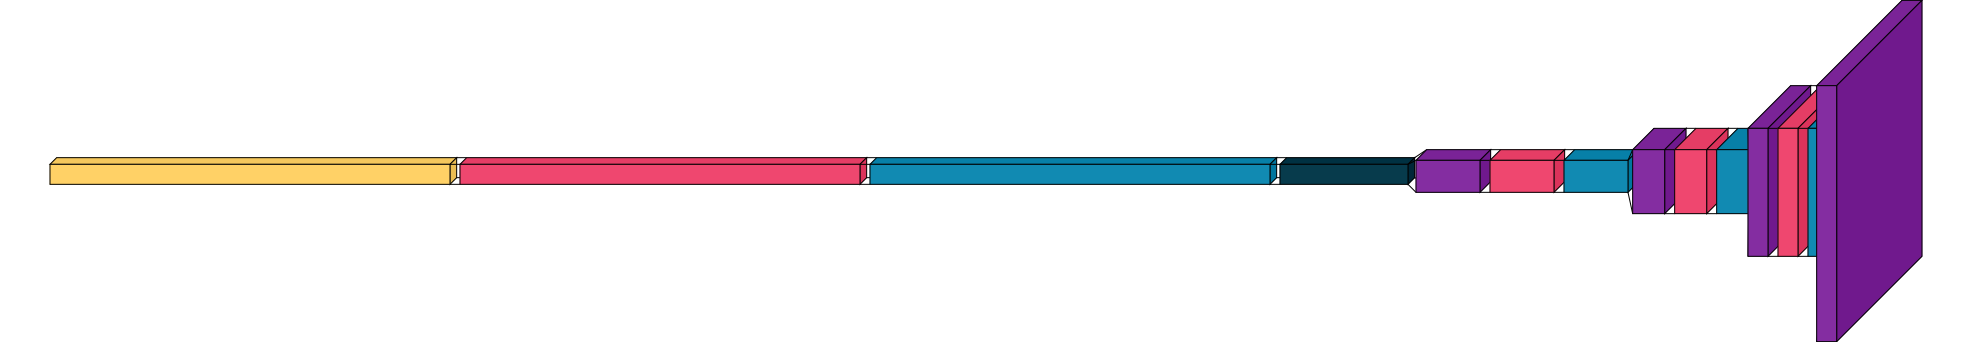

In [22]:
visualkeras.layered_view(

    generator,

    draw_volume=True,

    scale_xy=2,

    scale_z=0.5,

    padding=50

)

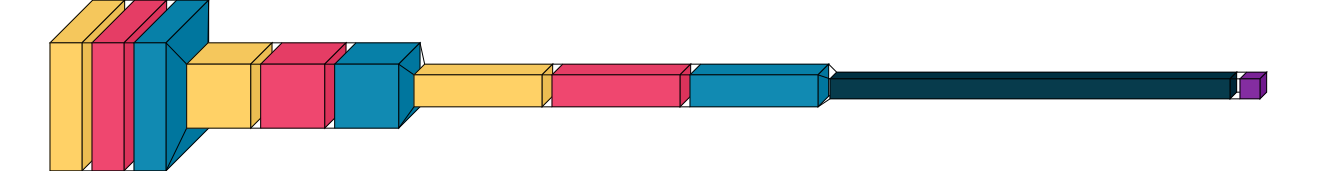

In [23]:
visualkeras.layered_view(

    discriminator,

    draw_volume=True,

    scale_xy=2,

    scale_z=0.5,

    padding=50

)

In [29]:
# Define loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([32, 100])  # Match the smaller batch size
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

save_dir="generated_frames"
os.makedirs(save_dir, exist_ok=True)
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)
    predictions = (predictions * 127.5 + 127.5).numpy().astype(np.uint8)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    # Save the whole figure as an image (a frame)
    plt.savefig(f"{save_dir}/epoch_{epoch:03d}.png")
    plt.close(fig)  # avoid displaying it every time

# Training loop
def train(dataset, epochs):
    seed = tf.random.normal([16, 100])  # Fixed seed for progress tracking
    for epoch in range(epochs):
        start_time = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        print(f"Time for epoch {epoch + 1}: {time.time() - start_time:.2f} sec")
        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

# Train the GAN
train(dataset, epochs=150)

Time for epoch 1: 93.86 sec
Time for epoch 2: 88.87 sec
Time for epoch 3: 88.79 sec


<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:#4B0082;">
        We define the <b>train_step</b> function to update the Generator and Discriminator 🎯.  
        We also save generated samples every 5 epochs to track progress visually 🖼️.
    </p>
</div>


<a id="result"></a>
# <p style="background-color:powderblue; font-family:roboto; color:navy; font-size:145%;font-weight:bold; text-align:center; border-radius:25px 10px; padding: 10px">6 - Results & Generated Faces 😸</p>

⬆️ [Table of Contents](#c_table)

In [ ]:
def create_training_animation(frame_dir="generated_frames", output_gif="training_progress.gif", zoom=3, figsize=(12, 12)):
    frame_paths = sorted(glob.glob(os.path.join(frame_dir, "epoch_*.png")))
    frames = []

    # Resize frames and store file names
    for path in frame_paths:
        img = Image.open(path)
        img = img.resize((img.width * zoom, img.height * zoom), Image.BICUBIC)  # Smoother resize
        frames.append((img, os.path.basename(path)))  # Save both image and filename

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    img_display = ax.imshow(frames[0][0])
    title = ax.set_title(frames[0][1], fontsize=16, color='navy')
    ax.axis('off')

    def update(i):
        img_display.set_data(frames[i][0])
        title.set_text(frames[i][1])
        return [img_display, title]

    anim = FuncAnimation(fig, update, frames=len(frames), interval=500, blit=True)
    anim.save(output_gif, writer=PillowWriter(fps=2))
    print(f"Animation saved as {output_gif}")

In [ ]:
create_training_animation()
display(IPyImage(filename="training_progress.gif"))

In [ ]:
anim_file = 'training_progress.gif'

# Create GIF from PNG images
with imageio.get_writer(anim_file, mode='I', duration=0.5) as writer:
    filenames = sorted(glob.glob('image*.png'))  # Make sure these files exist!
    for filename in filenames:
        image = Image.open(filename)
        image = image.resize((image.width * 2, image.height * 2), Image.NEAREST)  # optional: resize
        writer.append_data(np.array(image))

# Show the GIF in Kaggle Notebook
embed.embed_file(anim_file)

<div style="border-radius:10px; padding: 15px; background-color: #ADD8E6; font-size:115%; text-align:left">
    <p style="color:#4B0082;">
        In future projects, we may explore more advanced GANs or even Diffusion Models to improve results further 🚀.
    </p>
</div>


<font style="font-family:'Times New Roman', serif; font-size:200%;font-weight:bold;color:magenta;"> Best Regards!</font><br>